<a href="https://colab.research.google.com/github/rrsguim/PhD_Economics/blob/master/TL4OG/OutputGap_LSTM_BR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

------------------------------------------------------------------------------------------------------
Copyright (c) 2020 Rafael Guimaraes

This work was done when I was at the University of California, Riverside, USA. 

It is part of my doctoral thesis in Economics at the Federal University of 

Rio Grande do Sul, Porto Alegre, Brazil.


See full material at https://github.com/rrsguim/PhD_Economics

The code below, under the Apache License, was inspired by

*Classification on imbalanced data*, and 

*Introduction to the Keras Tuner*

Copyright 2020 The TensorFlow Authors

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

https://www.tensorflow.org/tutorials/keras/keras_tuner

-------------------------------------------------------------------------

# Transfer Learning for Output Gap Estimation

##Setup

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
!pip install -U keras-tuner

     |████████████████████████████████| 71kB 3.3MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=2d8612d15aa17d9d65c423aca9490b638e7953fb83bbdcb3f7095b5581a0aedd
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=430a8fa1ca303a856baf3ff19cca8fcfb2d1fc72f12f0c0b448595a504844fae
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
import tensorflow as tf
from tensorflow import keras

import IPython

import kerastuner as kt
from kerastuner import RandomSearch

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Deep Learning | Brazil

###Data loading and pre-processing

#### Download the data set

#### Data

There are two data sets for Brazil because of methodology changes in unemployment rate. Set 1 from 2001-IV to 2015-IV and Set 2 from 2012-II to 2020-III.

>Column| Source| Description| Feature Type | Data Type
>------------|--------------------|----------------------|-----------------|----------------
>Unemployment | FRED-MD | UNRATE - Unemployment rate, percent, s.a., quarterly average | Numerical | float
>Capacity | FRED-MD | TCU - Capacity utilization index, percent, s.a., quarterly average | Numerical | float
>TFP | FRED-MD | Total Factor Productivity Level at Current Purchasing Power Parities for Brazil, Index USA = 1 | Numerical | float
>Business cycle | CODACE | CODACE based Recession Indicator (1 = true; 0 = false) | Classification | integer
>GAP |  | Output Gap, percent | Numerical | float

In [ ]:
file = tf.keras.utils
#raw_data = pd.read_csv('https://raw.githubusercontent.com/rrsguim/PhD_Economics/master/TL4OG/TL4OG_BR_data_to2015.csv') #to 2015 (because of Unrate methodology)
raw_data = pd.read_csv('https://raw.githubusercontent.com/rrsguim/PhD_Economics/master/TL4OG/TL4OG_BR_data_since2012.csv') #since 2012 (because of Unrate methodology)

In [ ]:
raw_data.index = raw_data['DATE']
drop_DATE = raw_data.pop('DATE')
raw_data.index = pd.to_datetime(raw_data.index,infer_datetime_format=True)
raw_data.index = raw_data.index.to_period("Q")

Observe last lines of the adjusted dataset.

In [ ]:
raw_data.tail()

,unrate,tcu,tfp,CODACE,GAP
DATE,,,,,
2019Q3,11.80,75.53,0.506,0,-2.0
2019Q4,11.27,75.40,0.506,0,-1.9
2020Q1,11.67,75.73,0.506,1,-2.1
2020Q2,12.93,61.40,0.506,1,-4.9
2020Q3,14.27,75.27,0.506,1,-4.6


#### Inspect pre-processed data

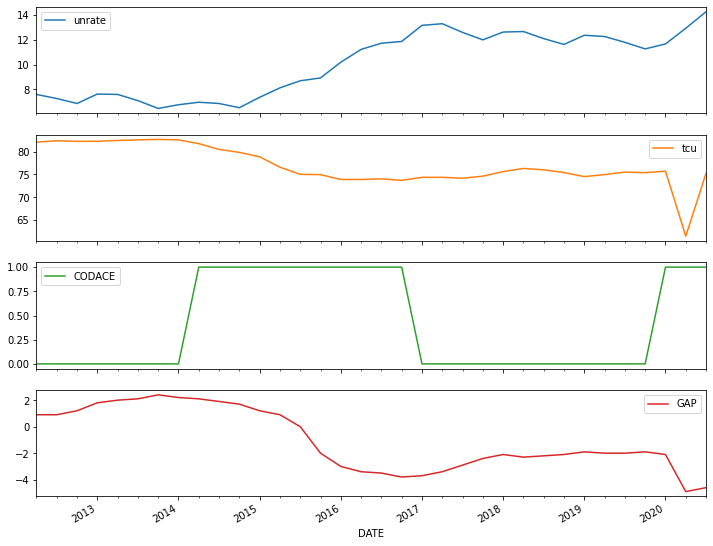

In [ ]:
plot_cols = ['unrate', 'tcu', 'CODACE', 'GAP'] 
plot_features = raw_data[plot_cols]
plot_features.index = raw_data.index
_ = plot_features.plot(subplots=True)

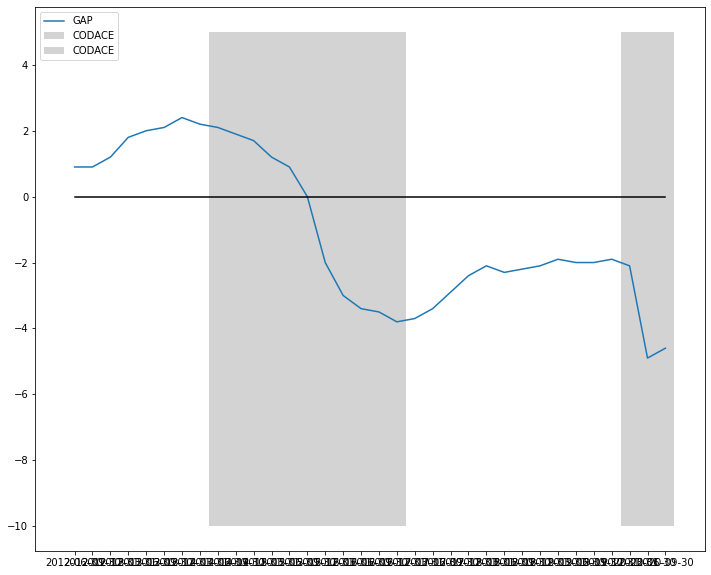

In [ ]:
plt.plot(drop_DATE, raw_data['GAP'], label='GAP')
plt.bar(drop_DATE, raw_data['CODACE']*-10 , width=1, linewidth=1, align='center', color="lightgray", label='CODACE') 
plt.bar(drop_DATE, raw_data['CODACE']*5 , width=1, linewidth=1, align='center', color="lightgray", label='CODACE') 
plt.plot(drop_DATE, np.zeros(drop_DATE.shape[0]), color='black')
plt.legend()
plt.show()

In [ ]:
raw_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unrate,34.0,10.074118,2.557549,6.470,7.4275,11.250,12.2275,14.270
tcu,34.0,76.961765,4.366775,61.400,74.5550,75.580,81.4825,82.730
tfp,34.0,0.544765,0.037840,0.506,0.5180,0.523,0.5830,0.608
CODACE,34.0,0.411765,0.499554,0.000,0.0000,0.000,1.0000,1.000
GAP,34.0,-1.026471,2.316385,-4.900,-2.7750,-2.000,1.2000,2.400


#### Split, but no shuffle

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however, the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data.

In [ ]:
# Use a utility from sklearn to split our dataset.
train_df, test_df = train_test_split(raw_data, test_size=0.2, random_state=0, shuffle=False)  #
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=0, shuffle=False) 
print(len(train_df), 'train examples')
print(len(val_df), 'validation examples')
print(len(test_df), 'test examples') 



21 train examples
6 validation examples
7 test examples


#### Normalize

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.


In [ ]:
#CODACE is a dummy, so we don't normalize it. We also don't normalize the target (GAP)
CODACE_train = train_df.pop('CODACE')
GAP_train = train_df.pop('GAP')
CODACE_val = val_df.pop('CODACE')
GAP_val = val_df.pop('GAP')
CODACE_test = test_df.pop('CODACE')
GAP_test = test_df.pop('GAP')

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

#put CODACE and GAP back
train_df['CODACE'] = CODACE_train
train_df['GAP'] = GAP_train
val_df['CODACE'] = CODACE_val
val_df['GAP'] = GAP_val
test_df['CODACE'] = CODACE_test
test_df['GAP'] = GAP_test

#### Split features from labels

In [ ]:
# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('GAP'))
val_labels = np.array(val_df.pop('GAP'))
test_labels = np.array(test_df.pop('GAP'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

### DL model

Adjust model input dim because of LSTM

In [ ]:
train_features = np.expand_dims(train_features, 1)
val_features = np.expand_dims(val_features, 1)
test_features = np.expand_dims(test_features, 1)

#### Define the model and metrics

Define a function that creates a deep neural network with LSTM and densly connected hidden layers, regularizers to reduce overfitting, and an output layer that returns the output gap estimation. Also, pick the optimal set of hyperparameters with [Keras Tunner](https://www.tensorflow.org/tutorials/keras/keras_tuner).

In [ ]:
def make_model(hp):  

  model = keras.Sequential()
  # Tune the number of units in the layers
  # Choose an optimal value between 16-256
  hp_lstm_units = hp.Int('lstm_units', min_value = 16, max_value = 256, step = 16)
  hp_dense_units = hp.Int('dense_units', min_value = 16, max_value = 256, step = 16)


### LSTM ###
  # Tune the dropout
  # Choose an optimal value from 0.2 to 0.7
  hp_dropout = hp.Float('dropout', 0.2, 0.7, step=0.1, default=0.5)

  model.add(keras.layers.LSTM(units = hp_lstm_units, input_shape = (1,train_features.shape[-1],), dropout = hp_dropout))
### LSTM ###


### DENSE ###
  # Tune the lambda for the regularizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_reg_lambda = hp.Choice('reg_lambda', values = [1e-2, 1e-3, 1e-4])

  #Tune the activation function
  hp_activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')

  #LASSO (L1)
  model.add(keras.layers.Dense(units = hp_dense_units, kernel_regularizer=keras.regularizers.l1(hp_reg_lambda), activation = hp_activation)) #Dense layer 1
  model.add(keras.layers.Dense(units = hp_dense_units, kernel_regularizer=keras.regularizers.l1(hp_reg_lambda), activation = hp_activation)) #Dense layer 2
  model.add(keras.layers.Dense(units = hp_dense_units, kernel_regularizer=keras.regularizers.l1(hp_reg_lambda), activation = hp_activation)) #Dense layer 3
  model.add(keras.layers.Dense(units = hp_dense_units, kernel_regularizer=keras.regularizers.l1(hp_reg_lambda), activation = hp_activation)) #Dense layer 4

  #Ridge (L2)
  #model.add(keras.layers.Dense(units = hp_dense_units, kernel_regularizer=keras.regularizers.l2(hp_reg_lambda), activation = hp_activation)) #Dense layer 1
  #model.add(keras.layers.Dense(units = hp_dense_units, kernel_regularizer=keras.regularizers.l2(hp_reg_lambda), activation = hp_activation)) #Dense layer 2
  #model.add(keras.layers.Dense(units = hp_dense_units, kernel_regularizer=keras.regularizers.l2(hp_reg_lambda), activation = hp_activation)) #Dense layer 3
  #model.add(keras.layers.Dense(units = hp_dense_units, kernel_regularizer=keras.regularizers.l2(hp_reg_lambda), activation = hp_activation)) #Dense layer 4 
### DENSE ###


  model.add(keras.layers.Dense(1)) # Output layer


  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])


  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                #optimizer = keras.optimizers.Adagrad(learning_rate = hp_learning_rate),
                loss = keras.losses.MeanSquaredError(), 
                metrics = [keras.metrics.MeanAbsoluteError()])
   
  return model

#TL4OG_model = make_model()


In [ ]:
tuner = kt.Hyperband(make_model, 
                     kt.Objective('val_mean_absolute_error', direction='min'), #
                     max_epochs = 50,) #15
                     #factor = 3,)
                     #project_name = 'TL4OG')

#### Train the model

Before running the hyperparameter search, define a callback to clear the training outputs at the end of every training step.

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

Run the hyperparameter search. The arguments for the search method are the same as those used for tf.keras.model.fit in addition to the callback above.

In [ ]:
tuner.search(train_features, train_labels,
             epochs=50,
             validation_data=(val_features, val_labels), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the lstm layer is {best_hps.get('lstm_units')}, in the densely-connected
layers is {best_hps.get('dense_units')}, while the activation function is {best_hps.get('dense_activation')}, the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}, the optimal lambda for the regularizer is {best_hps.get('reg_lambda')}, and the optimal dropout for the LSTM is {best_hps.get('dropout')}.
""")

Trial 90 Complete [00h 00m 06s]
val_mean_absolute_error: 0.19999265670776367

Best val_mean_absolute_error So Far: 0.11397389322519302
Total elapsed time: 00h 05m 40s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the lstm layer is 16, in the densely-connected
layers is 240, while the activation function is tanh, the optimal learning rate for the optimizer
is 0.01, the optimal lambda for the regularizer is 0.01, and the optimal dropout for the LSTM is 0.4000000000000001.



Retrain the model with the optimal hyperparameters from the search.

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
baseline_history = model.fit(train_features, train_labels,
             epochs=200,
             validation_data=(val_features, val_labels))

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 105.2008 - mean_absolute_error: 2.1073 - val_loss: 86.6222 - val_mean_absolute_error: 0.7750
Epoch 2/200
1/1 [==============================] - 0s 134ms/step - loss: 89.2852 - mean_absolute_error: 1.6961 - val_loss: 74.2063 - val_mean_absolute_error: 0.5992
Epoch 3/200
1/1 [==============================] - 0s 48ms/step - loss: 78.8619 - mean_absolute_error: 1.8686 - val_loss: 63.4405 - val_mean_absolute_error: 0.2185
Epoch 4/200
1/1 [==============================] - 0s 49ms/step - loss: 65.6366 - mean_absolute_error: 1.3128 - val_loss: 53.9404 - val_mean_absolute_error: 0.1611
Epoch 5/200
1/1 [==============================] - 0s 52ms/step - loss: 55.9693 - mean_absolute_error: 1.2937 - val_loss: 45.7525 - val_mean_absolute_error: 0.4193
Epoch 6/200
1/1 [==============================] - 0s 50ms/step - loss: 47.9368 - mean_absolute_error: 1.2639 - val_loss: 38.5612 - val_mean_absolute_error: 0.4900
Epoch 7/200
1/1 

#### Results

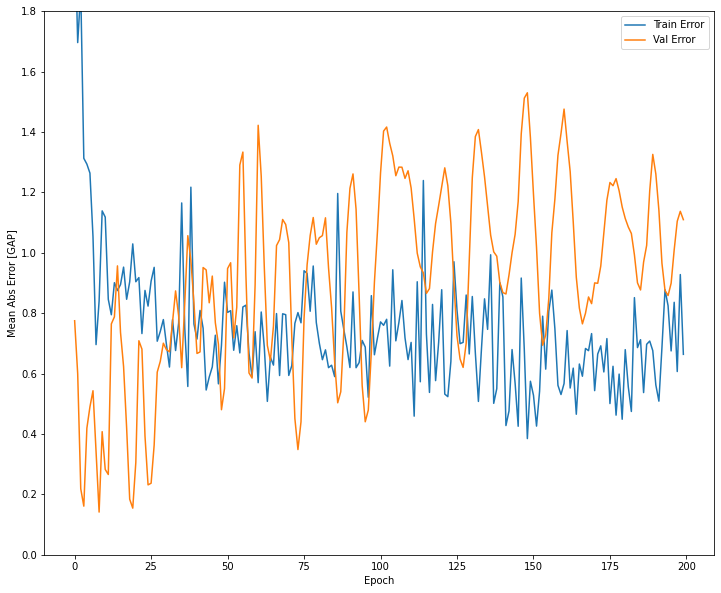

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [GAP]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,1.8])
  plt.legend()

  plt.show()


plot_history(baseline_history)

Training set

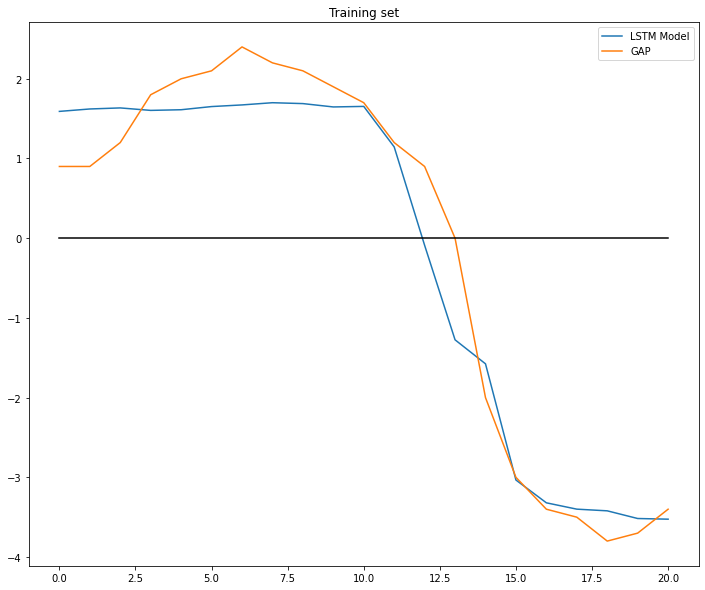

In [ ]:
time_axis_train = range(0,train_labels.shape[0])
plt.title('Training set')
plt.plot(time_axis_train, model.predict(train_features).flatten(), label='LSTM Model') ### Training set
plt.plot(time_axis_train, train_labels, label='GAP')
plt.plot(time_axis_train, np.zeros(train_labels.shape[0]), color='black')
plt.legend()
plt.show()

Test set

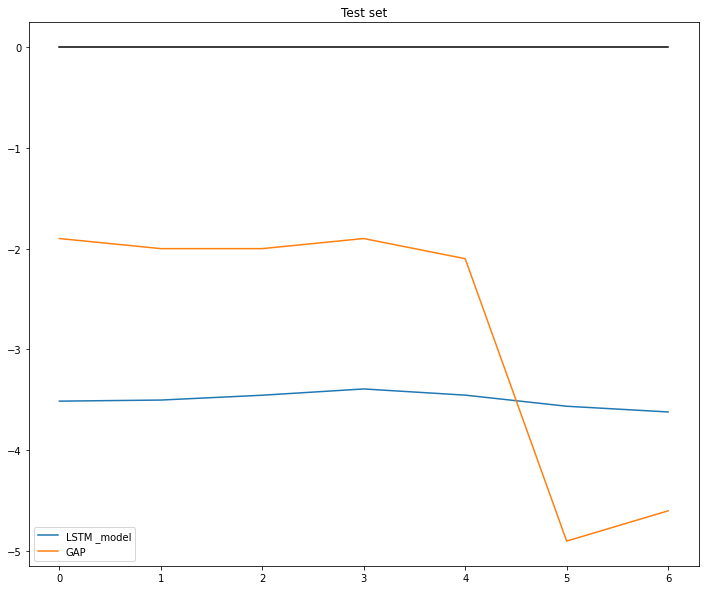

In [ ]:
time_axis_test = range(0,test_labels.shape[0]) #Test set
LSTM_model = model.predict(test_features) # Test set
plt.title('Test set')
plt.plot(time_axis_test, LSTM_model, label='LSTM _model')
plt.plot(time_axis_test, test_labels, label='GAP')
plt.plot(time_axis_test, np.zeros(test_labels.shape[0]), color='black')
plt.legend()
plt.show()

In [ ]:
BR_test_error = LSTM_model.flatten() - test_labels
MAE_test_set = np.sum(np.abs(BR_test_error))/BR_test_error.shape
MAE_test_set

array([1.38991276])

All data

In [ ]:
x = raw_data

#Normalize
#NBER is a dummy, so we don't normalize it. The GAP is not normalized too.
CODACE_x = x.pop('CODACE')
GAP_x = x.pop('GAP')

x_mean = x.mean()
x_std = x.std()
x = (x - x_mean) / x_std

#put CODACE and GAP back
x['CODACE'] = CODACE_x
x['GAP'] = GAP_x

#split labels
y = x.pop('GAP')

In [ ]:
x = np.expand_dims(x, 1) # (because of LSTM)

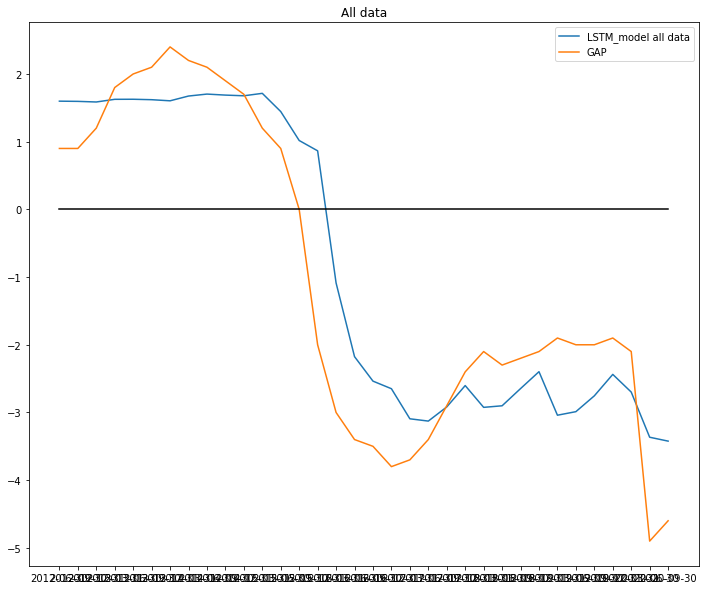

In [ ]:
LSTM_model_all_data = model.predict(x) # All data
plt.title('All data') 
plt.plot(drop_DATE, LSTM_model_all_data, label='LSTM_model all data')
plt.plot(drop_DATE, y, label='GAP')
plt.plot(drop_DATE, np.zeros(drop_DATE.shape[0]), color='black')
plt.legend()
plt.show()